# Task 2: Experimentation and uplift testing

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

- 3 stores, store 77, 86 and 88 have been selected to have trialed the new layout for chips category, trial period is from February 2019 to end of April 2019.
- To measure the impact of the new store layouts on sales during the period we first need to select a control store from the dataset, and in our dataset we have data from July 2018 to June 2019.
- When looking at control store, we look at stores that have similar performance as the trial store, for this we consider monthly overall sales revenue, monthly number of customers and the monthly number of transactions per customer.
- So we should calculate these metrics at a monthly store level, making sure to consider only stores that have sales every month over July 2018 to June 2019.
- Use analysis above based on the metrics above to determine the suitable control store.
- We also need to rank how similar each potential control is similar to the trial store, we can do this by working out either how correlated the store performances are, or a combination metric that considers how different each potential control store is to the trial store in every month.
- Once we have selected control stores for each of the trial stores, assess the impact of the trial on sales. We will need to check if the trial stores have significantly different results to the control stores. Consider visualizing this on graphs.

- To get started, use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store. 

This can be broken down by:
- total sales revenue
- total number of customers
- average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.



# Import Libraries

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [5]:
merged_df = pd.read_csv('./merged_data.csv')

In [6]:
merged_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  object 
 1   STORE_NBR         246740 non-null  int64  
 2   LYLTY_CARD_NBR    246740 non-null  int64  
 3   TXN_ID            246740 non-null  int64  
 4   PROD_NBR          246740 non-null  int64  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int64  
 7   TOT_SALES         246740 non-null  float64
 8   PACK_SIZE         246740 non-null  float64
 9   BRAND             246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 22.6+ MB


# Extract Month-Year from Date

In [9]:
def preprocess_data(df):
    df['DATE'] = pd.to_datetime(merged_df['DATE'])
    df['MONTH'] = merged_df['DATE'].dt.to_period('M')
    return df


In [10]:
merged_df = preprocess_data(merged_df)
merged_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural,YOUNG SINGLES/COUPLES,Premium,2018-10
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs,MIDAGE SINGLES/COUPLES,Budget,2019-05
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths,MIDAGE SINGLES/COUPLES,Budget,2019-05
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths,MIDAGE SINGLES/COUPLES,Budget,2018-08
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle,MIDAGE SINGLES/COUPLES,Budget,2018-08


# Computing Monthly Sales Metrics
- total sales revenue
- total number of customers
- average number of transactions per customer

In [12]:
# Step 2: Compute Monthly Metrics
def calculate_monthly_metrics(df):
    monthly_metrics = df.groupby(['STORE_NBR', 'MONTH']).agg(
        total_sales=('TOT_SALES', 'sum'),
        unique_customers=('LYLTY_CARD_NBR', pd.Series.nunique),
        total_transactions=('TXN_ID', pd.Series.nunique)
    )
    monthly_metrics['transactions_per_customer'] = (
        monthly_metrics['total_transactions'] / monthly_metrics['unique_customers']
    )
    return monthly_metrics.reset_index()

In [13]:
monthly_metrics = calculate_monthly_metrics(merged_df)
monthly_metrics

,STORE_NBR,MONTH,total_sales,unique_customers,total_transactions,transactions_per_customer
0,1,2018-07,188.9,47,49,1.042553
1,1,2018-08,168.4,41,41,1.000000
2,1,2018-09,268.1,57,59,1.035088
3,1,2018-10,175.4,39,40,1.025641
4,1,2018-11,184.8,44,45,1.022727
...,...,...,...,...,...,...
3160,272,2019-02,385.3,44,47,1.068182
3161,272,2019-03,421.9,48,51,1.062500
3162,272,2019-04,445.1,54,55,1.018519
3163,272,2019-05,314.6,34,40,1.176471


# Filter Stores with Complete Data
-  making sure to consider only stores that have sales every month over July 2018 to June 2019.

In [15]:
def filter_stores_with_complete_data(monthly_metrics):
    valid_stores = monthly_metrics.groupby('STORE_NBR')['MONTH'].nunique() == 12
    return monthly_metrics[monthly_metrics['STORE_NBR'].isin(valid_stores[valid_stores].index)]

In [16]:
filtered_metrics = filter_stores_with_complete_data(monthly_metrics)
filtered_metrics

,STORE_NBR,MONTH,total_sales,unique_customers,total_transactions,transactions_per_customer
0,1,2018-07,188.9,47,49,1.042553
1,1,2018-08,168.4,41,41,1.000000
2,1,2018-09,268.1,57,59,1.035088
3,1,2018-10,175.4,39,40,1.025641
4,1,2018-11,184.8,44,45,1.022727
...,...,...,...,...,...,...
3160,272,2019-02,385.3,44,47,1.068182
3161,272,2019-03,421.9,48,51,1.062500
3162,272,2019-04,445.1,54,55,1.018519
3163,272,2019-05,314.6,34,40,1.176471


# Visualizing Monthly Sales Metrics

In [18]:
def visualize_monthly_sales(metrics_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='MONTH', y='total_sales', hue='STORE_NBR', legend=False)
    plt.xticks(rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.title("Monthly Sales Revenue Across Stores")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='MONTH', y='unique_customers', hue='STORE_NBR', legend=False)
    plt.xticks(rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Unique Customers")
    plt.title("Monthly Unique Customers Across Stores")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='MONTH', y='transactions_per_customer', hue='STORE_NBR', legend=False)
    plt.xticks(rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Transactions per Customer")
    plt.title("Monthly Transactions per Customer Across Stores")
    plt.show()

In [19]:
# Copy Dataframe
filtered_metrics_copy = monthly_metrics.copy()

# Ensure MONTH is in datetime format
filtered_metrics_copy['MONTH'] = pd.to_datetime(filtered_metrics_copy['MONTH'], errors='coerce')

# Ensure total_sales is numeric
filtered_metrics_copy['total_sales'] = pd.to_numeric(filtered_metrics_copy['total_sales'], errors='coerce')

# Replace inf with NaN and only drop NaN values in total_sales
filtered_metrics_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop only rows where total_sales is NaN (avoid dropping everything)
filtered_metrics_copy = filtered_metrics.dropna(subset=['total_sales'])


In [20]:
# Convert Period to Timestamp (datetime)
filtered_metrics_copy['MONTH'] = filtered_metrics_copy['MONTH'].dt.to_timestamp()

C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


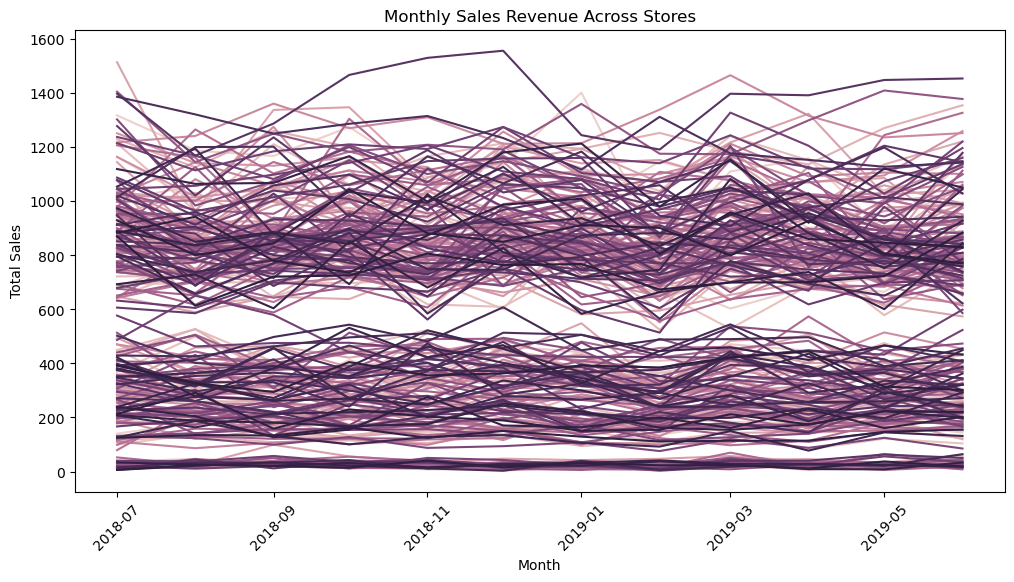

C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


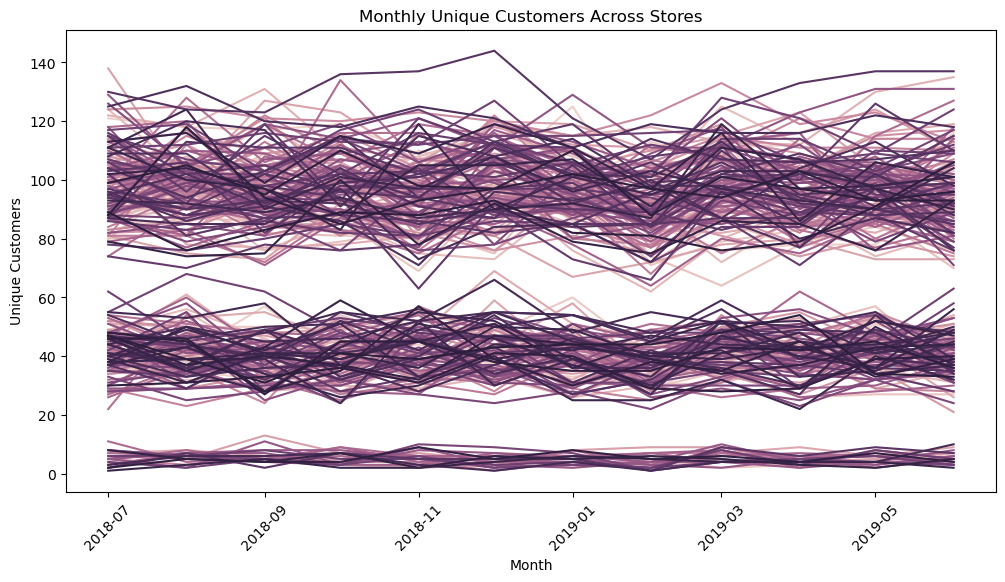

C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tinot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


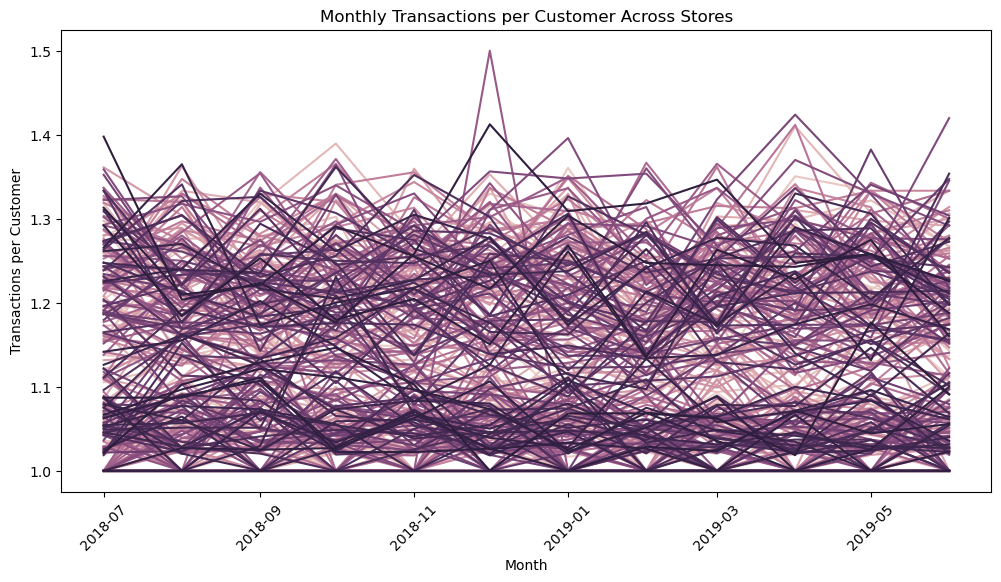

In [21]:
visualize_monthly_sales(filtered_metrics_copy)

# Finding Similarity & Select Control Store
- control_stores will provide the best matching control store for each trial store.

In [23]:
def compute_similarity(trial_store, metrics_df):
    trial_data = metrics_df[metrics_df['STORE_NBR'] == trial_store].set_index('MONTH')
    potential_controls = metrics_df[metrics_df['STORE_NBR'] != trial_store]
    
    similarities = []
    for store in potential_controls['STORE_NBR'].unique():
        store_data = potential_controls[potential_controls['STORE_NBR'] == store].set_index('MONTH')
        merged = trial_data.join(store_data, lsuffix='_trial', rsuffix='_control', how='inner')
        
        correlations = {
            'sales_corr': pearsonr(merged['total_sales_trial'], merged['total_sales_control'])[0],
            'customers_corr': pearsonr(merged['unique_customers_trial'], merged['unique_customers_control'])[0],
            'transactions_corr': pearsonr(merged['transactions_per_customer_trial'], merged['transactions_per_customer_control'])[0]
        }
        avg_correlation = np.mean(list(correlations.values()))
        similarities.append((store, avg_correlation))
    
    control_store = max(similarities, key=lambda x: x[1])
    return control_store[0]

In [24]:
# Selecting control stores
trial_stores = [77, 86, 88]
trial_period = pd.period_range('2019-02', '2019-04', freq='M')
control_stores = {store: compute_similarity(store, filtered_metrics) for store in trial_stores}
control_stores

C:\Users\tinot\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\tinot\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\tinot\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\tinot\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\tinot\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the corr

{77: 167, 86: 176, 88: 229}

In [57]:
# Convert the control_stores dictionary into a DataFrame
control_stores_df = pd.DataFrame(list(control_stores.items()), columns=['Trial Store', 'Control Store'])

# Display the DataFrame
control_stores_df


,Trial Store,Control Store
0,77,167
1,86,176
2,88,229


# Analyzing Trial Impact

In [26]:
def assess_impact(trial_store, control_store, metrics_df, trial_period):
    trial_data = metrics_df[(metrics_df['STORE_NBR'] == trial_store) & (metrics_df['MONTH'].isin(trial_period))]
    control_data = metrics_df[(metrics_df['STORE_NBR'] == control_store) & (metrics_df['MONTH'].isin(trial_period))]
    
    plt.figure(figsize=(10, 5))
    plt.plot(trial_data['MONTH'].astype(str), trial_data['total_sales'], label='Trial Store', marker='o')
    plt.plot(control_data['MONTH'].astype(str), control_data['total_sales'], label='Control Store', marker='o')
    plt.xticks(rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.title(f"Sales Comparison: Trial Store {trial_store} vs Control Store {control_store}")
    plt.legend()
    plt.show()
    
    t_stat, p_value = ttest_ind(trial_data['total_sales'], control_data['total_sales'])
    print(f"T-test results: t-stat={t_stat:.3f}, p-value={p_value:.3f}")


Assessing impact for Trial Store 77 (Control Store: 167)


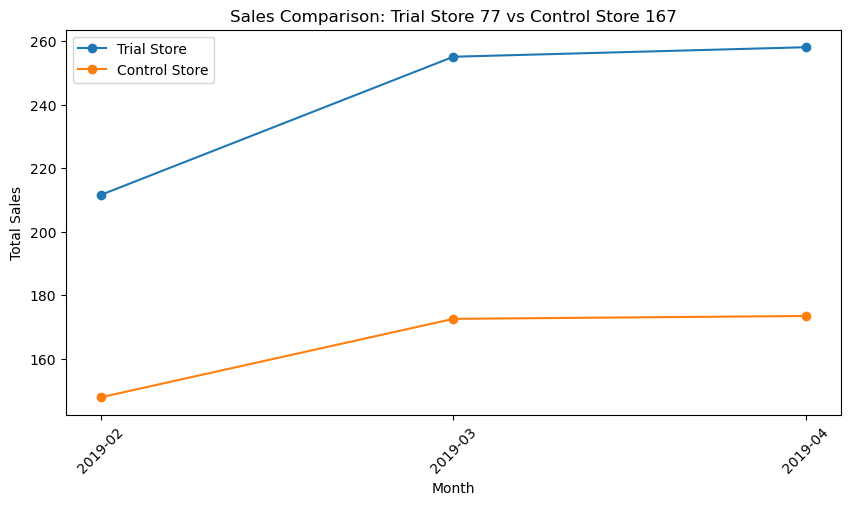

T-test results: t-stat=4.477, p-value=0.011
Assessing impact for Trial Store 86 (Control Store: 176)


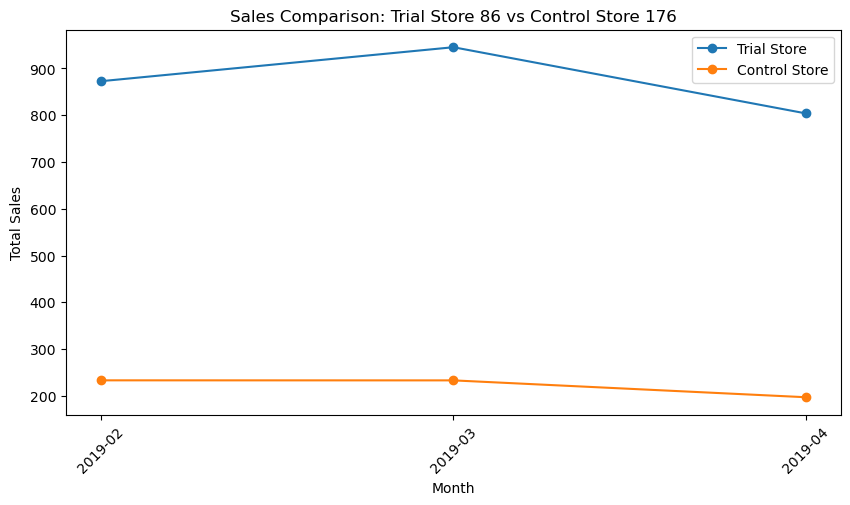

T-test results: t-stat=15.341, p-value=0.000
Assessing impact for Trial Store 88 (Control Store: 229)


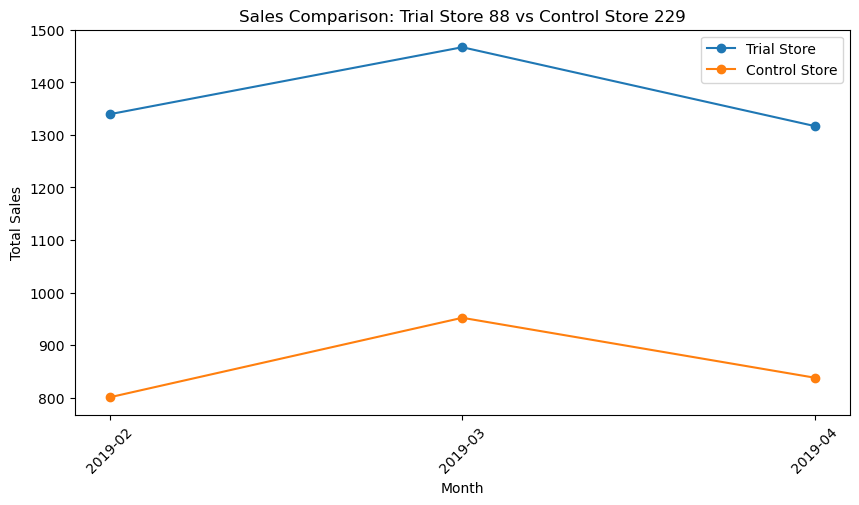

T-test results: t-stat=7.838, p-value=0.001


In [27]:
# Assessing trial impact
for trial_store, control_store in control_stores.items():
    print(f"Assessing impact for Trial Store {trial_store} (Control Store: {control_store})")
    assess_impact(trial_store, control_store, filtered_metrics, trial_period)